**Introduction :**

On s'intéresse à la résolution de l'équation diagnostique :

$$q = \Delta \psi - \lambda \psi$$

Le but est d'explorer plusieurs méthode de résolution de cette équation.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Solve_EqDiagnostic_Psi(object):
    '''Classe qui résout l'équation q = laplacien(psi) - lambda*psi'''
    def __init__(self, lbda, domain):
        self.lbda = lbda
        self.domain = domain
        self.dim = len(domain.shape)
       
    
    def solve_fft(self, q):
        fft_list_freq = [2*np.pi*np.fft.fftfreq(self.domain.shape[i], self.domain.lengths[i]/self.domain.shape[i]) for i in range(self.dim)]
        if self.dim == 1:
            fft_q = np.fft.fft(q)
            k_square = fft_list_freq[0]**2
        elif self.dim == 2:
            fft_q = np.fft.fft2(q)
            fft_xx, fft_yy = np.meshgrid(fft_list_freq[0], fft_list_freq[1])
            k_square = (fft_xx**2 + fft_yy**2)
        fft_psi = -1/(k_square + self.lbda)*fft_q
        if self.dim == 1:
            return np.fft.ifft(fft_psi).real
        elif self.dim == 2:
            return np.fft.ifft2(fft_psi).real
    
    def solve_Jacobi(self, q, psi, max_iter = 10000, eps = 0.1):
        
        #correction du biais
        psi = (psi - psi.mean() - q.mean()/self.lbda)
        
        i = 0
        e_q = (q - (self.laplacien(psi) - lbda*psi))/q
        while  any(e > eps for e in np.ndarray.flatten(e_q)) and i < max_iter:
            psi = 1/(lbda+2*sum(1/np.array(self.domain.dx)**2))*(sum([(np.roll(psi, 1, axis=i) + np.roll(psi, -1, axis=i))/self.domain.dx[-i-1]**2 for i in range(len(self.domain.shape))]) - q)
            e_q = (self.laplacien(psi) - lbda*psi) - q
            i += 1
        return(psi, i)
    
    def validate_Solution(self, q, psi):
        q_diagnostic = self.laplacien(psi) - self.lbda* psi
        norm_error = sum(np.abs(q-q_diagnostic)**2)
        print("norme de l'erreur :", norm_error)    
        
        
    def laplacien(self, f):
        laplace_f = 0
        for i in range(self.dim):
            laplace_f += (np.roll(f, 1, axis = i) + np.roll(f, -1, axis = i) - 2*f)/(self.domain.dx[-(i+1)]**2)
        return laplace_f

# I. Définition du Domaine et des conditions initiales

In [3]:
import sympy
sympy.init_printing() 

In [4]:
from sympy import Function, Derivative, Eq, symbols, factor
from sympkf import PDESystem, FDModelBuilder

In [5]:
t, x, y = symbols('t x y')
lbda = symbols('lambda')

q_1D = Function('q')(t, x)
psi_1D = Function('psi')(t, x)

q_2D = Function('q')(t ,x ,y)
psi_2D = Function('psi')(t, x, y)

In [6]:
# set the equations
Equation_1D = [Eq(Derivative(psi_1D, t), 0)]
Equation_2D = [Eq(Derivative(psi_2D, t), 0)]

In [7]:
PDESystem(Equation_1D), PDESystem(Equation_2D)

(PDE System :
         prognostic functions : psi(t, x)
         constant functions   : 
         exogeneous functions : 
         constants            : 
         ,
 PDE System :
         prognostic functions : psi(t, x, y)
         constant functions   : 
         exogeneous functions : 
         constants            : 
         )

In [8]:
# set the lengths of the domain
lengths_1D = (1,)
lengths_2D = (1,1)

# set yhe number of points
nx, ny = (241,241)
shape_1D = (lengths_1D[0]*nx,)
shape_2D = (lengths_2D[0]*nx,lengths_2D[1]*ny)

# set lambda
lbda = 0.01

In [9]:
# generate the domain

exec(FDModelBuilder(Equation_1D, class_name='Psi_1D').code)
pkf_psi_1D = Psi_1D(shape_1D, lengths = lengths_1D)
exec(FDModelBuilder(Equation_2D, class_name='Psi_2D').code)
pkf_psi_2D = Psi_2D(shape_2D, lengths= lengths_2D)

In [10]:
domain_1D = pkf_psi_1D
domain_2D = pkf_psi_2D

In [11]:
print("domain_1D :", domain_1D.shape, domain_1D.lengths)
print("domain_2D :", domain_2D.shape, domain_2D.lengths)

domain_1D : (241,) (1,)
domain_2D : (241, 241) (1, 1)


In [12]:
def make_sample_1D(lhq=0.1):
    
    # create correletion matrix
    gauss_q = lambda dx : np.exp(-0.5*dx**2/lhq**2)  

    correlation_q = gauss_q(domain_1D.x[0]-domain_1D.x[0][domain_1D.shape[0]//2])
    spectrum_q = np.abs(np.fft.fft(correlation_q))
    std_spectrum_q = np.sqrt(spectrum_q)
    
    
    # make sample
    zeta = np.random.normal(size=domain_1D.shape[0])
    zeta_q = np.fft.fft(zeta)
    
    ef_q = np.fft.ifft(std_spectrum_q * zeta_q)
    
    ef_q = np.real(ef_q)
    
    return ef_q




def make_sample_2D(lhx = 0.1, lhy = 0.1):
    
    # create correletion matrix
    x_mesh, y_mesh = np.meshgrid(domain_2D.x[0], domain_2D.x[1])

    gauss_q = lambda dx, dy : np.exp(-0.5*((dx**2)/(lhx**2) + (dy**2)/(lhy**2)))  

    correlation_q = gauss_q(domain_2D.x[0]-domain_2D.x[0][domain_2D.shape[0]//2], y_mesh-y_mesh[domain_2D.shape[1]//2])
    spectrum_q = np.abs(np.fft.fft2(correlation_q))
    std_spectrum_q = np.sqrt(spectrum_q)
    std_spectrum_q = np.ndarray.flatten(std_spectrum_q)
    
    
    
    # make sample
    zeta = np.random.normal(size=domain_2D.shape[0]*domain_2D.shape[1])
    
    zeta_q = np.fft.fft(zeta)
    ef_q = np.fft.ifft(std_spectrum_q*zeta_q)
    
    ef_q = np.real(ef_q)
    
    ef_q = np.reshape(ef_q, (domain_2D.shape[0],domain_2D.shape[1]))
    
    return ef_q

In [54]:
# Initialisation of q field
q_1D = make_sample_1D()
q_2D = make_sample_2D(0.05,0.05)

# II. Résolution par FFT

La résolution par transformée de Fourier consiste à décomposer les signaux dans l'espace spectral afin de simplifier la résolution de l'équation différenciel. Après calcul, on obtient dans le domaine spectrale l'équation suivante : 
$$\Psi_k = \frac{-1}{k^2+\lambda}q_k$$
Pour avoir le champs $\Psi$ réel, La transformée de Fourier inverse  est appliquée au spectre $\Psi_k$ afin de revenir dans l'espace physique.

## 1) Domaine 1D

In [54]:
solve_1D = Solve_EqDiagnostic_Psi(lbda, domain = domain_1D)

psi_1D = solve_1D.solve_fft(q_1D)

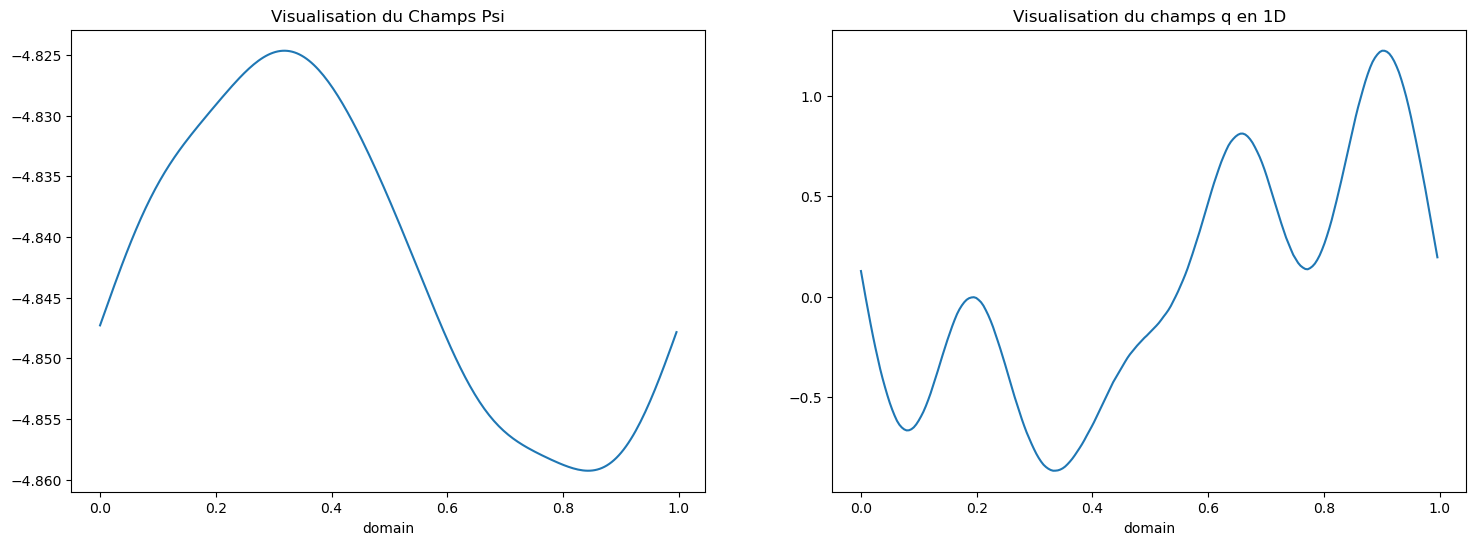

In [55]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.title('Visualisation du Champs Psi')
plt.xlabel('domain')
plt.plot(domain_1D.x[0], psi_1D)

plt.subplot(122)
plt.title('Visualisation du champs q en 1D')
plt.xlabel('domain')
plt.plot(domain_1D.x[0], q_1D)

norme de l'erreur : 1.742990582145818e-05


Text(0.5, 1.0, 'Comparaison du champs q initial et du champs q généré par psi')

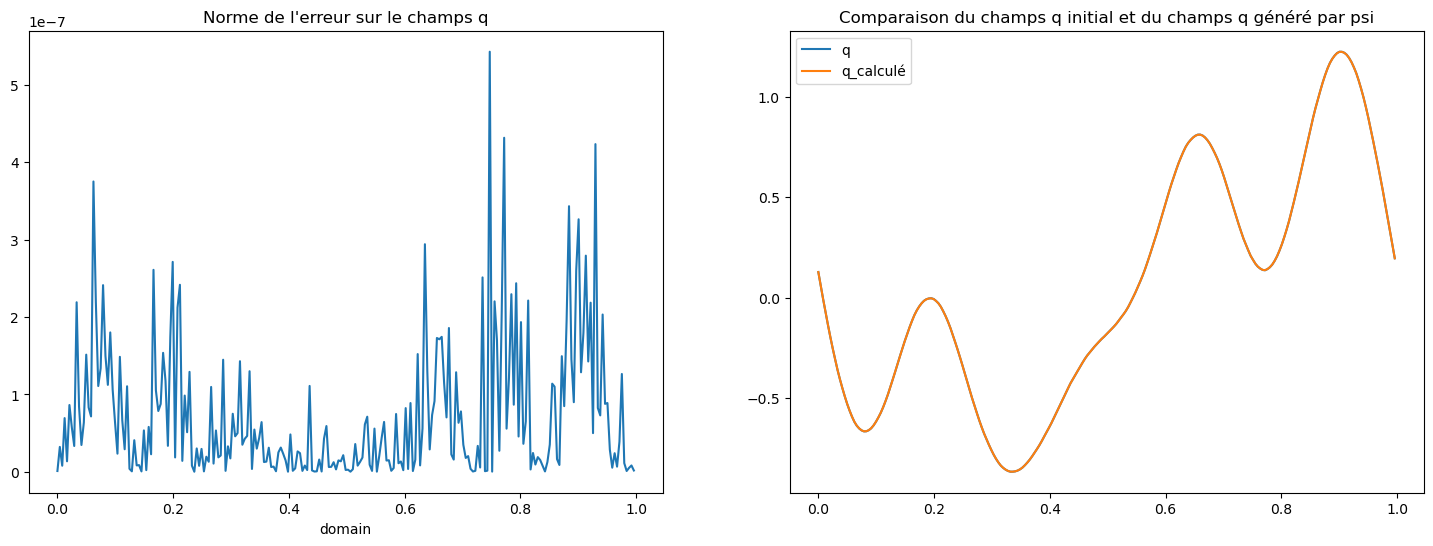

In [56]:
q_calculé = solve_1D.laplacien(psi_1D) - solve_1D.lbda*psi_1D
solve_1D.validate_Solution(q_1D, psi_1D)

plt.figure(figsize=(18,6))


plt.subplot(121)
plt.plot(domain_1D.x[0], np.abs(q_1D-q_calculé)**2)

plt.title("Norme de l'erreur sur le champs q")
plt.xlabel('domain')


plt.subplot(122)
plt.plot(domain_1D.x[0], q_1D)
plt.plot(domain_1D.x[0], q_calculé)

plt.legend(['q', 'q_calculé'])
plt.title('Comparaison du champs q initial et du champs q généré par psi')

## 2) Domaine 2D

In [57]:
solve_2D = Solve_EqDiagnostic_Psi(lbda, domain = domain_2D)

psi_2D = solve_2D.solve_fft(q_2D)

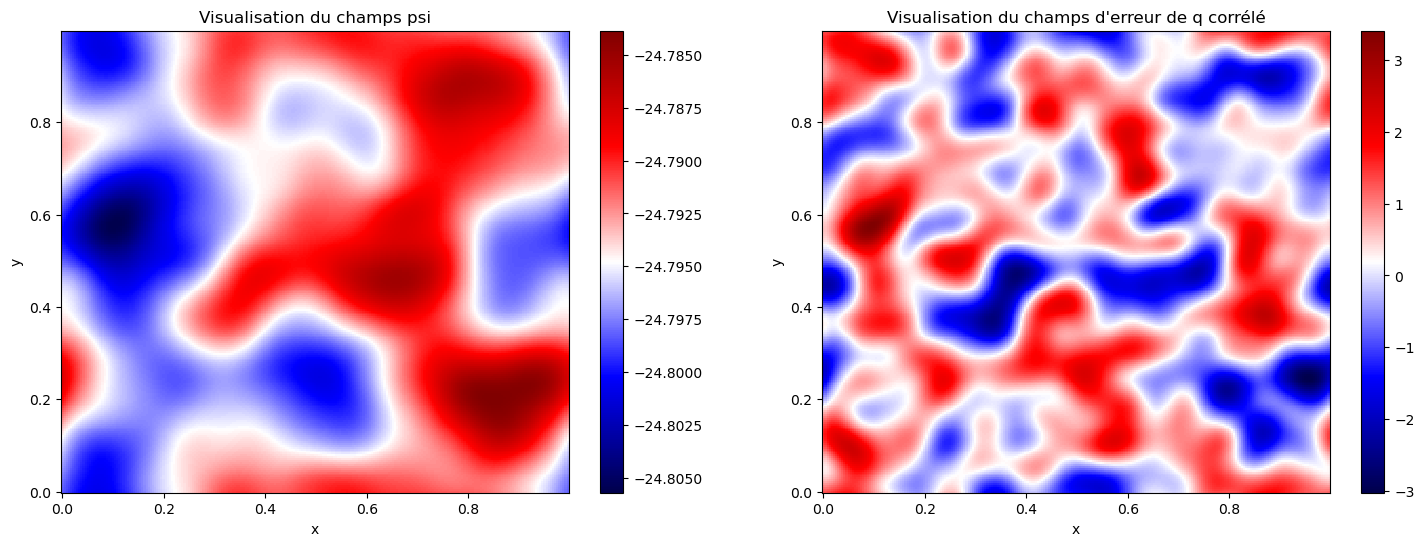

In [58]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.title('Visualisation du champs psi')
plt.xlabel('x')
plt.ylabel('y')

plt.pcolormesh(domain_2D.x[1], domain_2D.x[0], psi_2D, cmap = 'seismic')
plt.colorbar()

plt.subplot(122)
plt.title("Visualisation du champs d'erreur de q corrélé")
plt.xlabel('x')
plt.ylabel('y')

plt.pcolormesh(domain_2D.x[1], domain_2D.x[0], q_2D, cmap='seismic')
plt.colorbar()

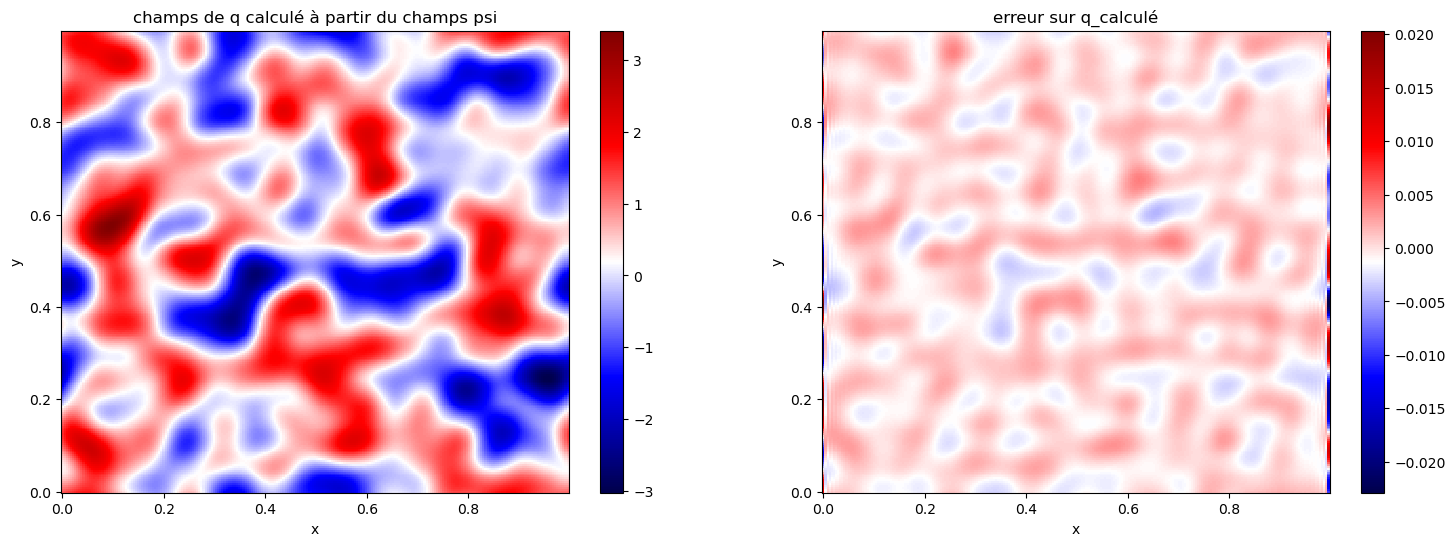

In [59]:
fig = plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.title('champs de q calculé à partir du champs psi')
plt.xlabel('x')
plt.ylabel('y')

plt.pcolormesh(domain_2D.x[1], domain_2D.x[0], solve_2D.laplacien(psi_2D) - lbda*psi_2D, cmap='seismic')
plt.colorbar()

plt.subplot(122)
plt.title("erreur sur q_calculé")
plt.xlabel('x')
plt.ylabel('y')

plt.pcolormesh(domain_2D.x[1], domain_2D.x[0], q_2D - (solve_2D.laplacien(psi_2D) - lbda*psi_2D), cmap = 'seismic')
plt.colorbar()

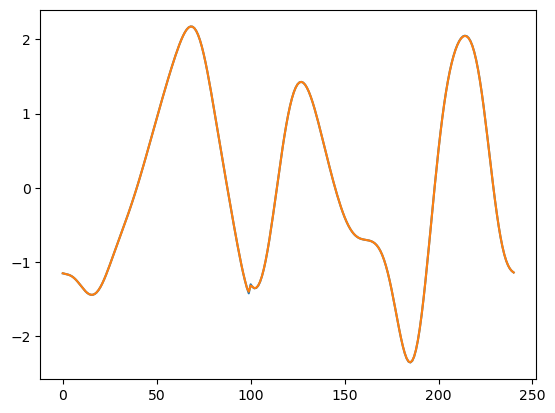

In [60]:
plt.plot(np.roll(q_2D[100], 100))
plt.plot(np.roll((solve_2D.laplacien(psi_2D) - lbda*psi_2D)[100], 100))

# II. Résolution par méthode Iterative

#### Méthode de Jacobi

La méthode de Jacobi est une méthode itérative simple qui permet de résoudre le système linéaire $Ax = b$. Elle consiste à corriger un champs de manière itérative pour qu'il corresponde au champs recherché. 
Dans cette méthode, A est décomposée par sa diagonale et ses parties triangulaire inférieure (L) et supérieur (U) :

$$A = D - L - U$$

A partir de cette formule, on peut écrire l'itération suivante :

$$x^{k+1} = D^{-1}(L+U)x^k + D^{-1}b$$

Pour l'équation 1D étudier, on a :

$D^{-1} = \frac{-1}{2+\lambda dx^2} \begin{pmatrix} 1 & 0 & ... & 0 & 0\\ 0 & 1 & ... & 0 & 0\\ ... & ... & ... & ... & ... \\ 0 & 0 & ... & 1 & 0 \\ 0 &  0 & ... & 0 & 1\end{pmatrix}$, $L = \frac{1}{dx^2}\begin{pmatrix} 0 & 0 & ... & 0 & 0\\ -1 & 0 & ... & 0 & 0\\ ... & ... & ... & ... & ... \\ 0 & 0 & ... & 0 & 0 \\ 0 &  0 & ... & -1 & 0\end{pmatrix}$, $U = \frac{1}{dx^2}\begin{pmatrix} 0 & -1 & ... & 0 & 0\\ 0 & 0 & ... & 0 & 0\\ ... & ... & ... & ... & ... \\ 0 & 0 & ... & 0 & -1 \\ 0 &  0 & ... & 0 & 0\end{pmatrix}$

## Domaine 1D

Text(0.5, 1.0, 'champs psi 1D à calculer')

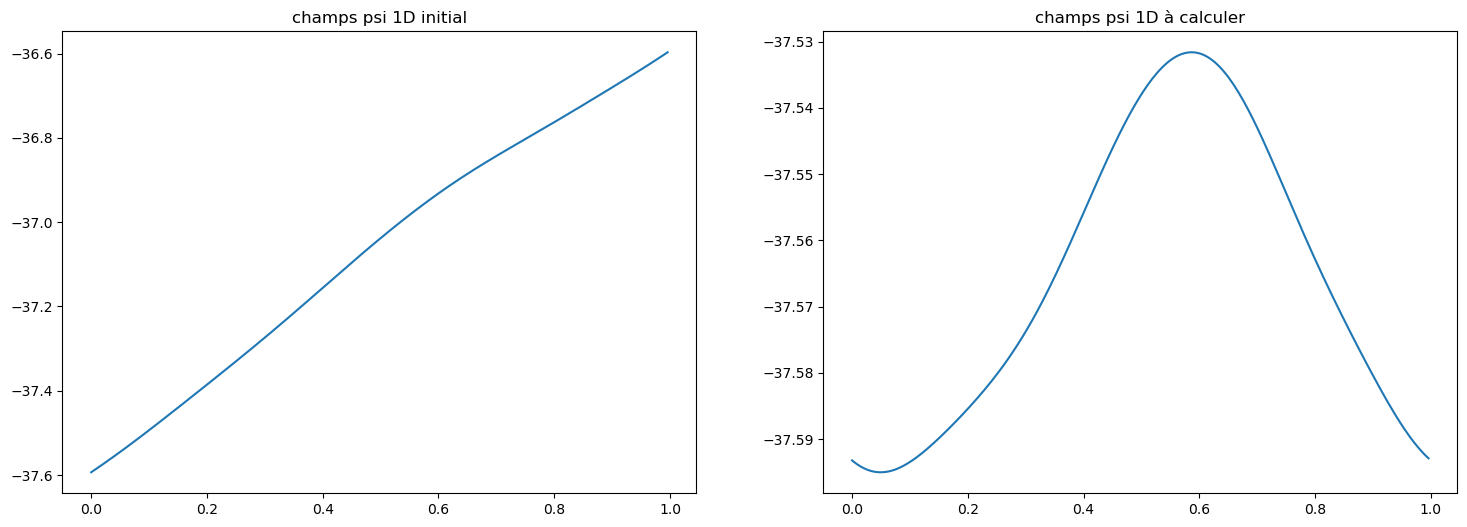

In [21]:
psi_1D_0 = psi_1D + domain_1D.x[0]

plt.figure(figsize = (18,6))

plt.subplot(1,2,1)
plt.plot(domain_1D.x[0], psi_1D_0)
plt.title('champs psi 1D initial')

plt.subplot(1,2,2)
plt.plot(domain_1D.x[0], psi_1D)
plt.title('champs psi 1D à calculer')

In [22]:
psi_Jacobi_1D, i = solve_1D.solve_Jacobi(q_1D, psi_1D_0, max_iter = 200000)
i

Text(0.5, 1.0, 'psi calculé par la méthode de Jacobi')

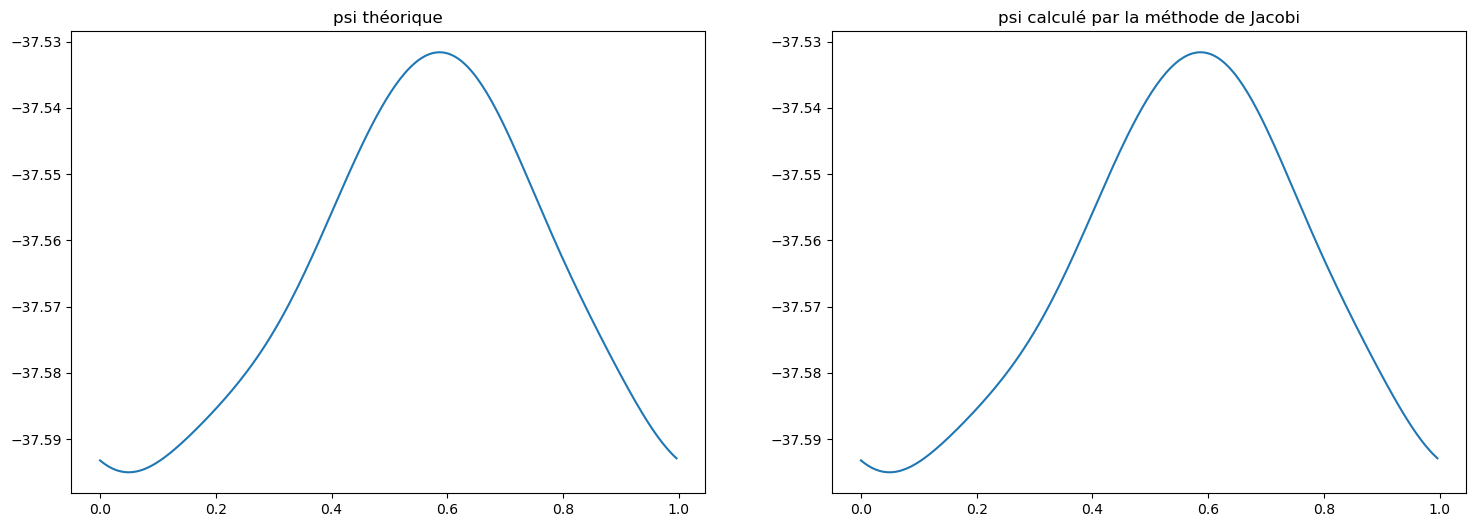

In [23]:
plt.figure(figsize = (18,6))

plt.subplot(121)
plt.plot(domain_1D.x[0], psi_1D)
plt.title('psi théorique')

plt.subplot(122)
plt.plot(domain_1D.x[0], psi_Jacobi_1D)
plt.title("psi calculé par la méthode de Jacobi")

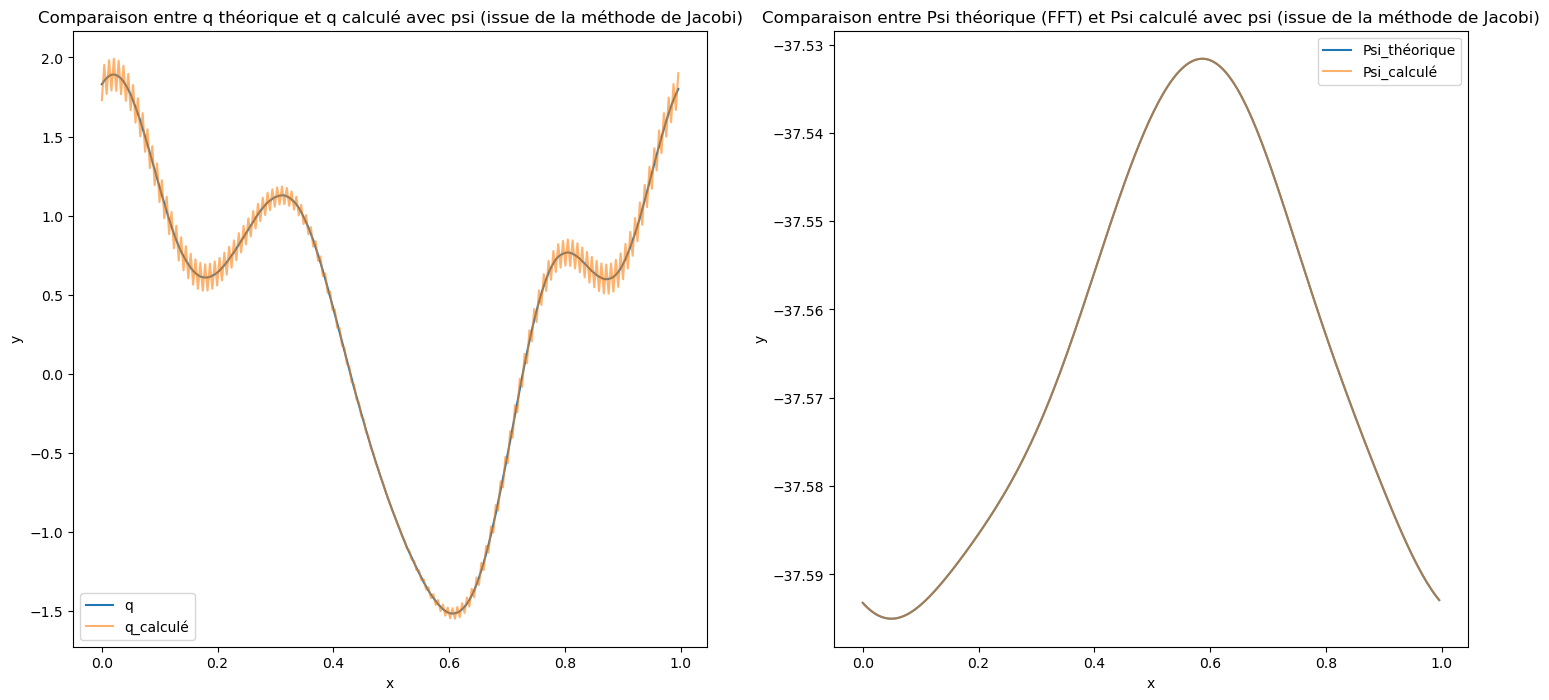

In [32]:
q_calculé_Jacobi_1D = solve_1D.laplacien(psi_Jacobi_1D) - solve_1D.lbda*psi_Jacobi_1D

plt.figure(figsize = (18,8))

plt.subplot(121)
plt.plot(domain_1D.x[0], q_1D)
plt.plot(domain_1D.x[0], q_calculé_Jacobi_1D, alpha = 0.6)

plt.title('Comparaison entre q théorique et q calculé avec psi (issue de la méthode de Jacobi)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['q', 'q_calculé'])

plt.subplot(122)
plt.plot(domain_1D.x[0], psi_1D)
plt.plot(domain_1D.x[0], psi_Jacobi_1D, alpha = 0.6)

plt.title('Comparaison entre Psi théorique (FFT) et Psi calculé avec psi (issue de la méthode de Jacobi)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Psi_théorique', 'Psi_calculé'])

On observe que l'amplitudes des erreurs sur le champs q sont plus importante que l'amplitude d'erreur que le champs Psi. 
Avoir une faible précision sur la  

## Domaine 2D

In [144]:
psi_2D_0 = psi_2D + domain_2D.x[0]

Text(0, 0.5, 'y')

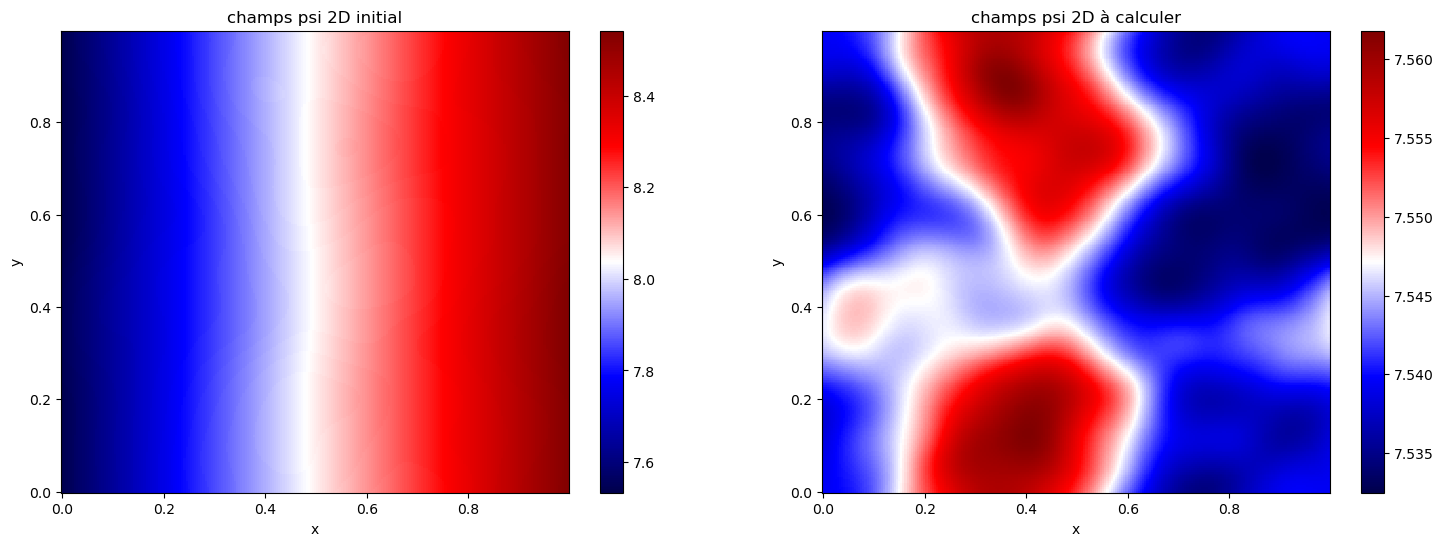

In [145]:
plt.figure(figsize = (18,6))

plt.subplot(1,2,1)
plt.pcolormesh(domain_2D.x[0], domain_2D.x[1], psi_2D_0, cmap = 'seismic')
plt.colorbar()
plt.title('champs psi 2D initial')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1,2,2)
plt.pcolormesh(domain_2D.x[0], domain_2D.x[1], psi_2D, cmap = 'seismic')
plt.colorbar()
plt.title('champs psi 2D à calculer')
plt.xlabel('x')
plt.ylabel('y')

In [146]:
psi_Jacobi_2D, i = solve_2D.solve_Jacobi(q_2D, psi_2D_0, max_iter = 40000)
i

Text(0, 0.5, 'y')

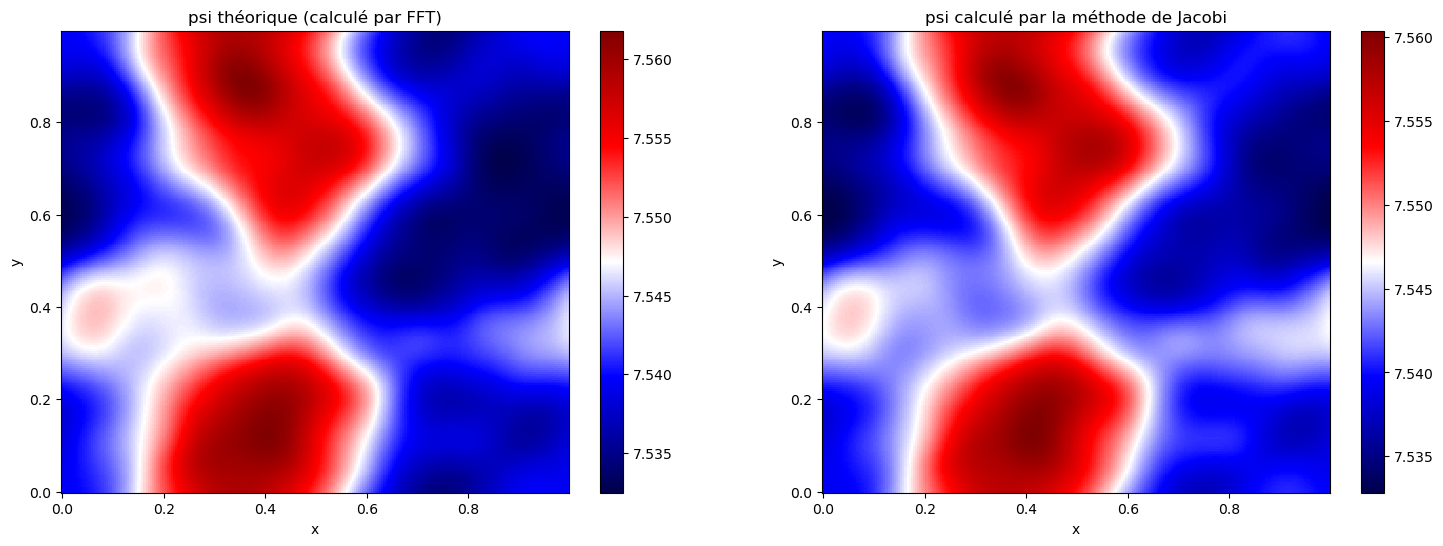

In [147]:
plt.figure(figsize = (18,6))

plt.subplot(121)
plt.pcolormesh(domain_2D.x[0], domain_2D.x[1], psi_2D, cmap = 'seismic')
plt.colorbar()
plt.title('psi théorique (calculé par FFT)')
plt.xlabel('x')
plt.ylabel('y')


plt.subplot(122)
plt.pcolormesh(domain_2D.x[0], domain_2D.x[1],  psi_Jacobi_2D, cmap = 'seismic')
plt.colorbar()
plt.title("psi calculé par la méthode de Jacobi")
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

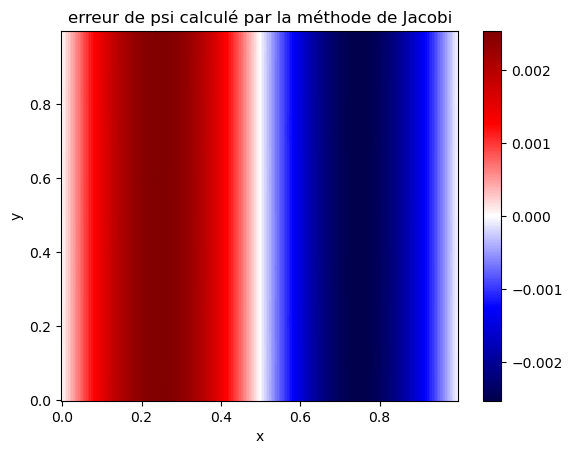

In [148]:
plt.pcolormesh(domain_1D.x[0], domain_2D.x[1], psi_2D - psi_Jacobi_2D, cmap='seismic')
plt.colorbar()
plt.title('erreur de psi calculé par la méthode de Jacobi')
plt.xlabel('x')
plt.ylabel('y')

La méthode de Jacobi est couteuse en temps de calcul. Néanmoins, cette méthode semble converger plus vite en 2D qu'en 1D. Sur un champs 2D? L'erreur obtenu sur q est de l'ordre de $10^{-3}$.

## Résolution par pseudo-dynamique de $\Psi$

In [149]:
from sympkf import Model

In [150]:
class Equation_Psi(Model):
    def __init__(self, lbda, q, domain):
        super().__init__(self)
        self.lbda = lbda
        self.q = q
        self.domain = domain
        self.dim = len(domain.x)
        
        
    def trend(self, psi):
        return self.laplacien(psi) - self.lbda
    
    def laplacien(self, f):
        laplace_f = 0
        for i in range(self.dim):
            laplace_f += (np.roll(f, 1, axis = i) + np.roll(f, -1, axis = i) - 2*f)/(self.domain.dx[-(i+1)]**2)
        return laplace_f